In [40]:
%load_ext autoreload
%autoreload 2
from tqdm import tqdm
from src.classes.ClassFractionalBiPotential import FractionalBiPotential
from src.classes.ClassFractionalQuadSin import FractionalQuadSin
import matplotlib.pyplot as plt
import numpy as np
from src.classes.ClassFractionalSinLog import FractionalSinLog
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_HighFTh_T256_H05_tl_110data_StbleTgt_WRMSE import get_config
#from configs.RecursiveVPSDE.Markovian_fSinLog.recursive_Markovian_PostMeanScore_fSinLog_HighFTh_T256_H05_tl_110data_StbleTgt_WRMSE import get_config
#from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_PostMeanScore_fBiPot_T256_H05_tl_110data_StbleTgt_WRMSE import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# From A ridge estimator of the drift from discrete repeated observations of the solutions of a stochastic differential equation (Denis et al 2021)

In [41]:
config = get_config()

In [42]:
def rmse_ignore_nans(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.mean((y_true[mask] - y_pred[mask]) ** 2)

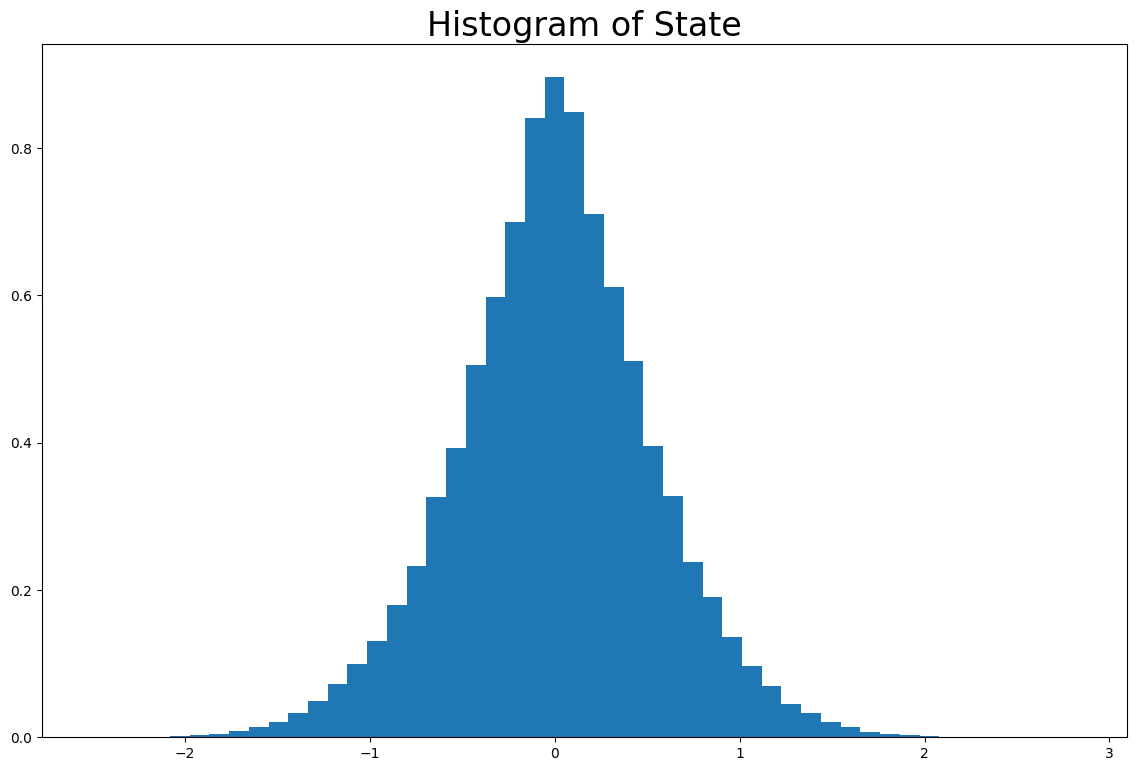

In [43]:
num_paths = 10240
num_time_steps = config.ts_length
isUnitInterval = True
diff = config.diffusion
initial_state = config.initState
rvs = None
H = config.hurst
deltaT = config.deltaT
t0 = config.t0
t1 = deltaT * num_time_steps
if "QuadSin" in config.data_path:
    fQuadSin = FractionalQuadSin(quad_coeff=config.quad_coeff, sin_coeff= config.sin_coeff, sin_space_scale=config.sin_space_scale, diff=diff, X0=initial_state)
    paths = np.array(
        [fQuadSin.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                               t0=t0, t1=t1) for _ in (range(num_paths))]).reshape(
        (num_paths, num_time_steps+1))
elif "fSinLog" in config.data_path:
    paths = np.load(config.data_path, allow_pickle=True)[:num_paths, :]
    paths = np.concatenate(
        [np.repeat(np.array(config.initState).reshape((1, 1)), paths.shape[0], axis=0),
         paths], axis=1)
    print(paths.shape, num_paths, config.ts_length + 1)
    assert paths.shape == (num_paths, config.ts_length + 1)

elif "fBiPot" in config.data_path:
    fBiPot = FractionalBiPotential(num_dims=config.ndims, const=config.const, quartic_coeff=config.quartic_coeff, quad_coeff = config.quad_coeff, diff=diff, X0=initial_state)
    paths = np.array(
        [fBiPot.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                               t0=t0, t1=t1) for _ in (range(num_paths))]).reshape(
        (num_paths, num_time_steps+1))

fig, ax = plt.subplots(figsize=(14,9))
plt.hist(paths.flatten(), bins=50, density=True)
plt.title("Histogram of State", fontsize=24)
plt.show()
plt.close()


In [44]:
print(np.min(paths), np.max(paths))
for k in range(num_paths, 1000):
    plt.plot(np.arange(1, 258), paths[k,:])
plt.show()

-2.5085433342599597 2.826633459226639


In [45]:
def spline_basis(paths, KN, AN, BN, M):
    assert (paths.shape[0] >= 1 and len(paths.shape)==2)
    assert (AN < BN and KN > 0 and M > 0)
    def construct_ith_knot(i, AN, BN, KN):
        if i < 0:
            return AN
        elif i > KN:
            return BN
        else:
            return AN + i*(BN-AN)/KN
    def bspline(i, l, u, x, KN, M):
        if l == 0 and -M <= i <= KN+M-1:
            return ((u[i] <= x) & (x < u[i+1])).astype(float)
        elif 1 <= l <= M  and -M <= i <= KN+M-l-1:
            num1 = ((x-u[i])/(u[i+l]-u[i]))
            num1[np.isinf(num1)] = 0.
            num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
            num2[np.isinf(num2)] = 0.
            return num1*bspline(i=i,l=l-1, u=u, x=x, KN=KN, M=M)+num2*bspline(i=i+1, l=l-1, u=u, x=x, KN=KN, M=M)

    knots = {i:construct_ith_knot(i, AN, BN, KN) for i in range(-M, KN+M+1)}
    if paths.shape[1] > 1:
        paths = paths[:,:-1].flatten()
    else:
        paths = paths.flatten()
    basis = np.array([bspline(i=i, l=M, u=knots, x=paths, KN=KN,M=M) for i in range(-M, KN)]).T
    assert (basis.shape == (paths.shape[0], KN+M)), f"Basis is shape {basis.shape} but should be {(paths.shape[0], KN+M)}"
    assert np.all(basis >= 0.)
    return basis

import scipy
def find_optimal_estimator_coeffs(B, Z, KN, LN, M):
    # Precompute certain matrices
    BTB = B.T@B
    BTZ = (B.T@Z)
    const = (KN+M)*LN
    if np.all(np.linalg.eigvalsh(BTB)>0.):
        print(f"Matrix BTB is invertible\n")
        a = np.linalg.inv(BTB)@BTZ
        if a.T@a <= const:
            print(f"L2 norm of coefficients automatically satisfies projection constraint\n")
            return a
    I = np.eye(KN+M)
    def obj(l):
        inv = np.linalg.inv(BTB+l*I) @ BTZ
        return np.abs(inv.T@inv - const)
    opt = scipy.optimize.minimize(obj, max(0.,-np.min(np.linalg.eigvalsh(BTB)))+1e-12)
    lhat = np.inf
    while not (opt.success) and not np.allclose(lhat, opt.x):
        lhat = opt.x
        opt = scipy.optimize.minimize(obj, opt.x)
    lhat = opt.x[0]
    a = np.atleast_2d(np.linalg.inv(BTB+lhat*I)@BTZ)
    assert (np.allclose(a.T@a , const))
    return a

def construct_estimator(coeffs, B, LN):
    drift  = B@coeffs
    drift[np.abs(drift) > np.sqrt(LN)] = np.sqrt(LN)*np.sign(drift[np.abs(drift) > np.sqrt(LN)])
    return drift


In [46]:
config.data_path

'/Users/marcos/GitHubRepos/FractionalBrownianMotion/data/fQuadSinHF_samples_t00_dT3906e-03_T256_05a_004b_250c_10Diff_00Init.npy'

In [47]:
AN = -1.5
BN = -AN
M = 3
LN = np.log(num_paths)
KNs = {2**p: np.inf for p in [0, 1, 3, 4, 5]}
for KN in list(KNs.keys()):
    break
    B = spline_basis(paths=paths[:num_paths,:], KN=KN, AN=AN, BN=BN, M=M)
    Z = np.power(deltaT,-1)*np.diff(paths[:num_paths,:], axis=1).reshape((paths[:num_paths,:].shape[0]*(paths.shape[1]-1),1))
    assert (B.shape[0] == Z.shape[0] and len(B.shape)==len(Z.shape) == 2)
    coeffs = find_optimal_estimator_coeffs(B=B, Z=Z, KN=KN, LN=LN, M=M)
    drift = construct_estimator(coeffs=coeffs, B=B, LN=LN).flatten()
    KNs[KN] = np.mean(np.power(drift-Z.flatten(),2)) + 0.1*np.power(np.log(num_paths),2)*(KN+M)/num_paths
#KN = list(dict(sorted(KNs.items(), key= lambda item: item[1])).keys())[0]

In [48]:
if "fQuadSin" in config.data_path:
    minx = -1.5
    if config.sin_space_scale == 25.:
        ts_type = "fQuadSin2"
    else:
        ts_type = "fQuadSin1"
elif "fSinLog" in config.data_path:
    minx = -1.5
    ts_type = "fSinLog"
elif "fBiPot" in config.data_path:
    minx = -1.5
    ts_type = "fBiPot"
maxx = -minx

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_27572/3788290958.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_27572/3788290958.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))


Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



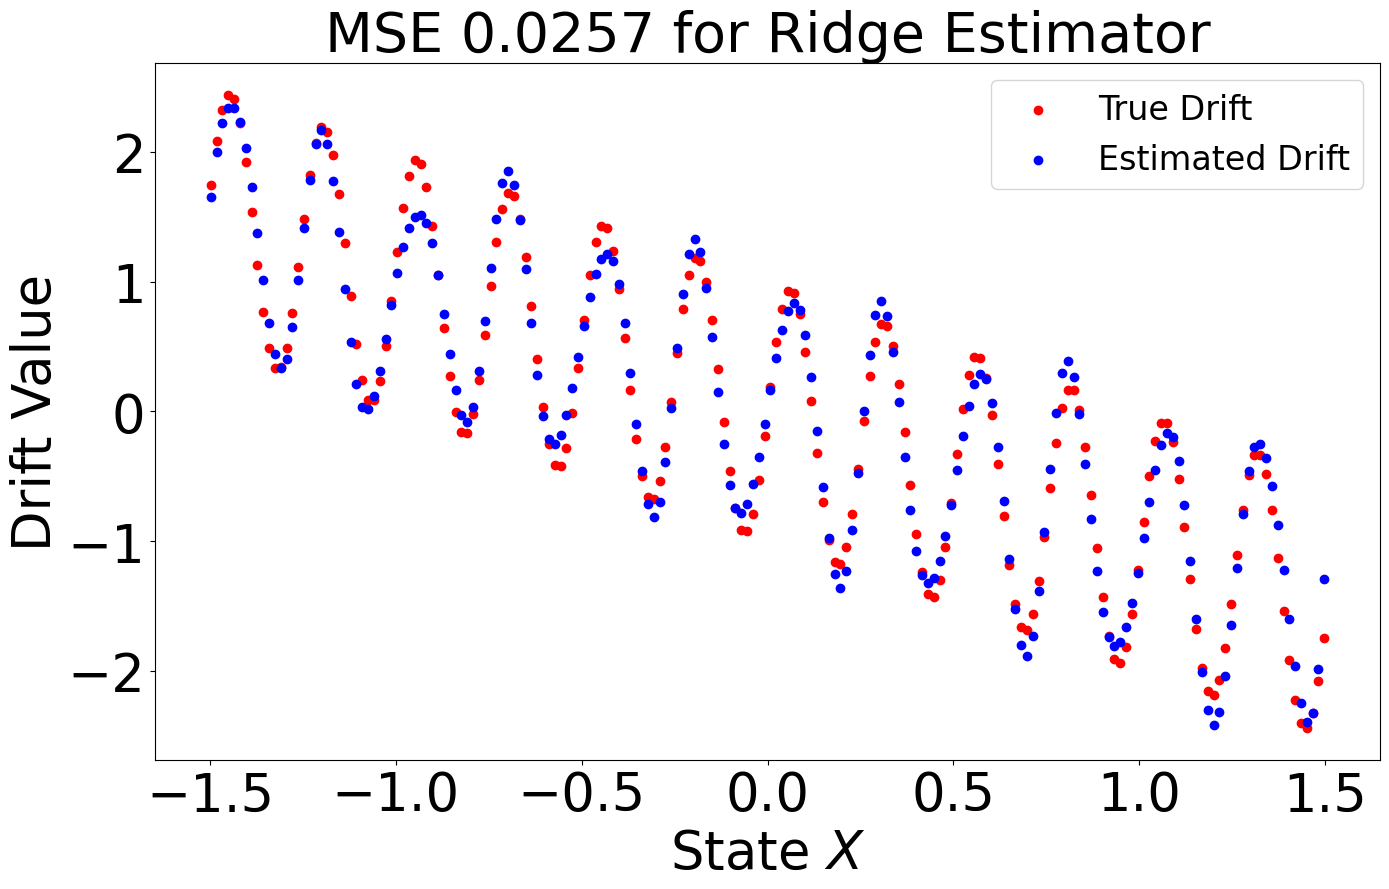

MSE 0.025748862938447973 for KN 30
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



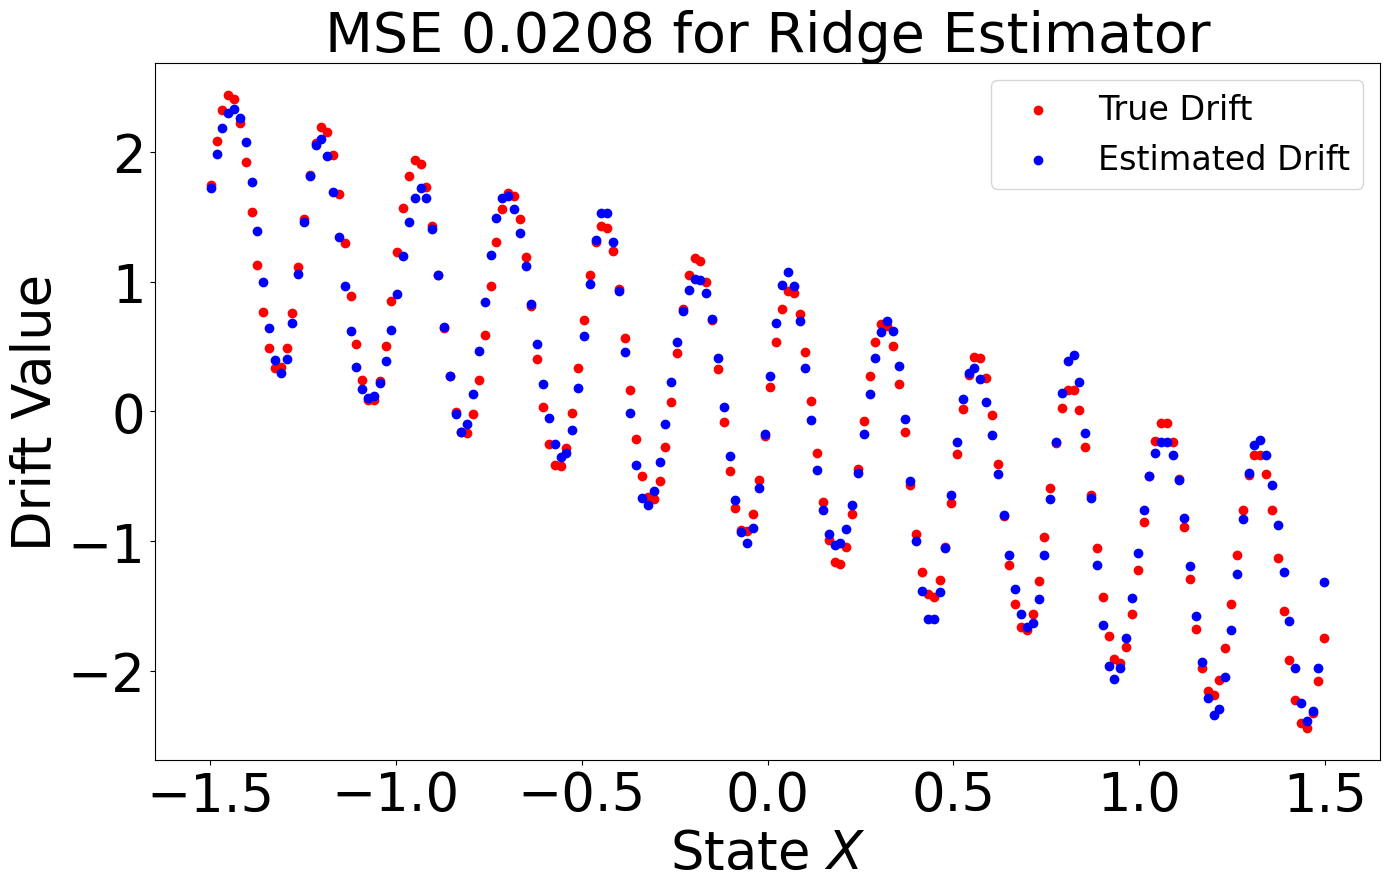

MSE 0.020807964542273915 for KN 31
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



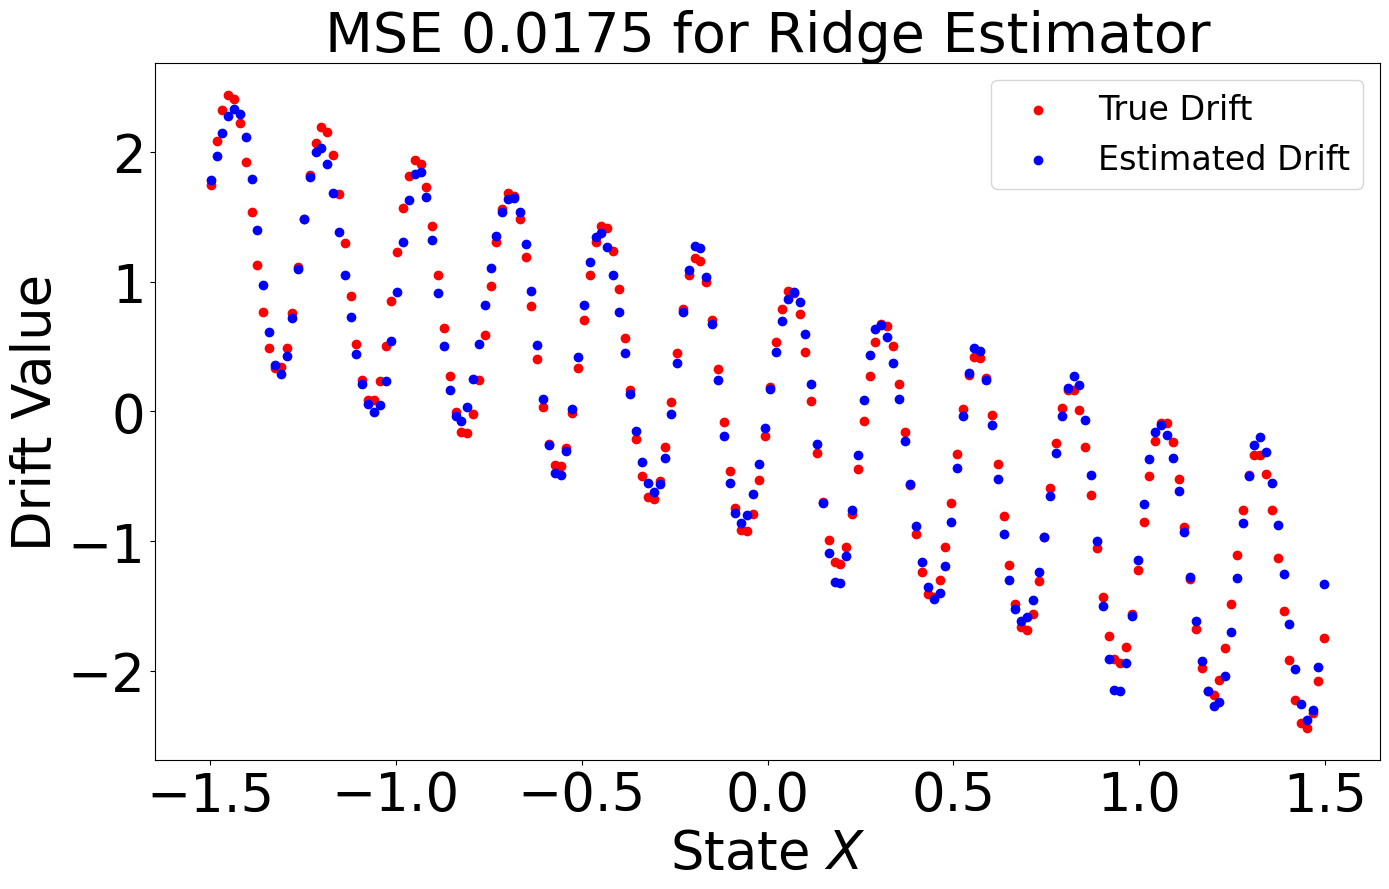

MSE 0.017484587894787688 for KN 32
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



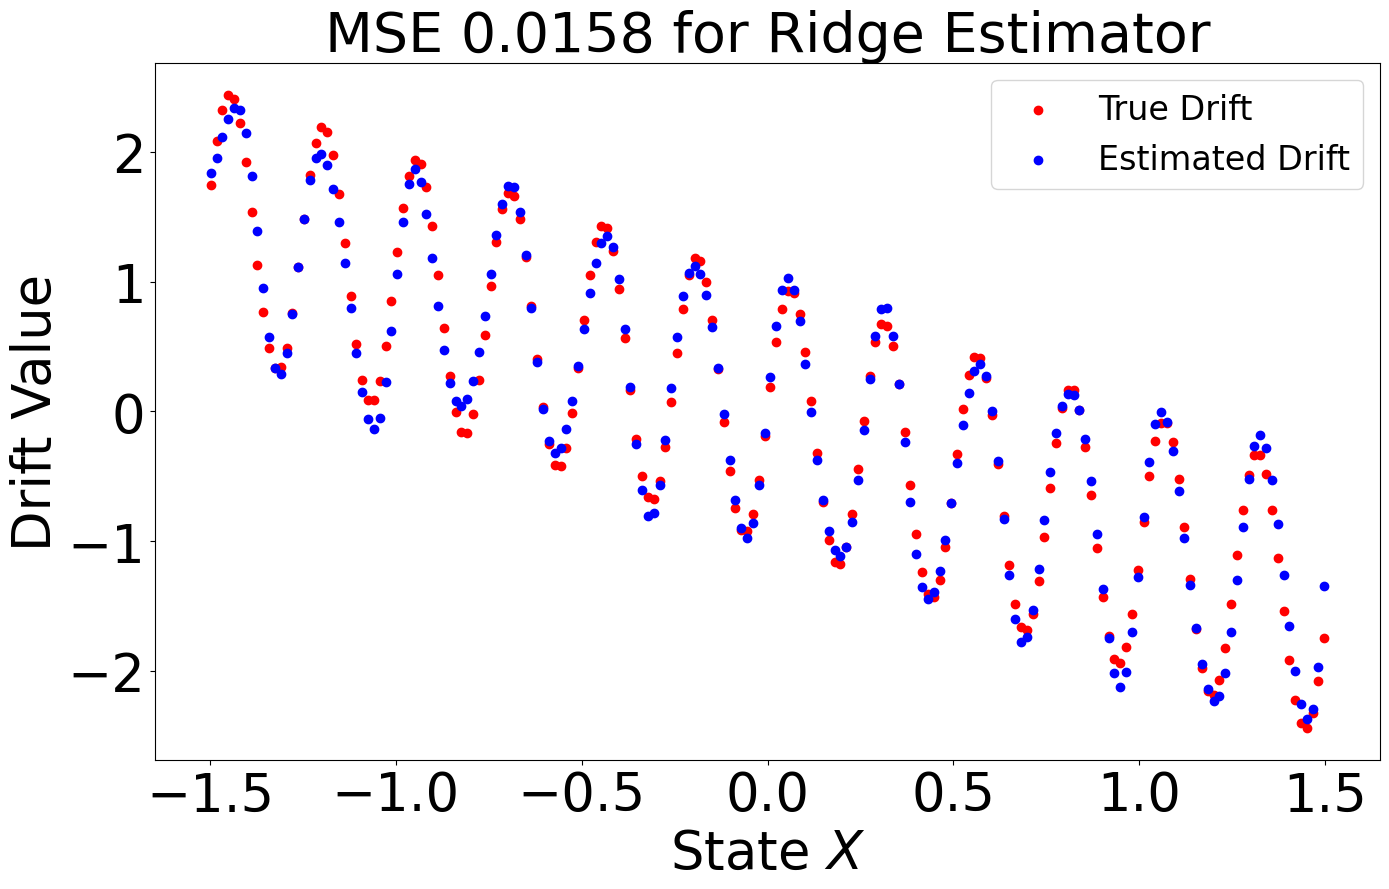

MSE 0.015823054128209824 for KN 33
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



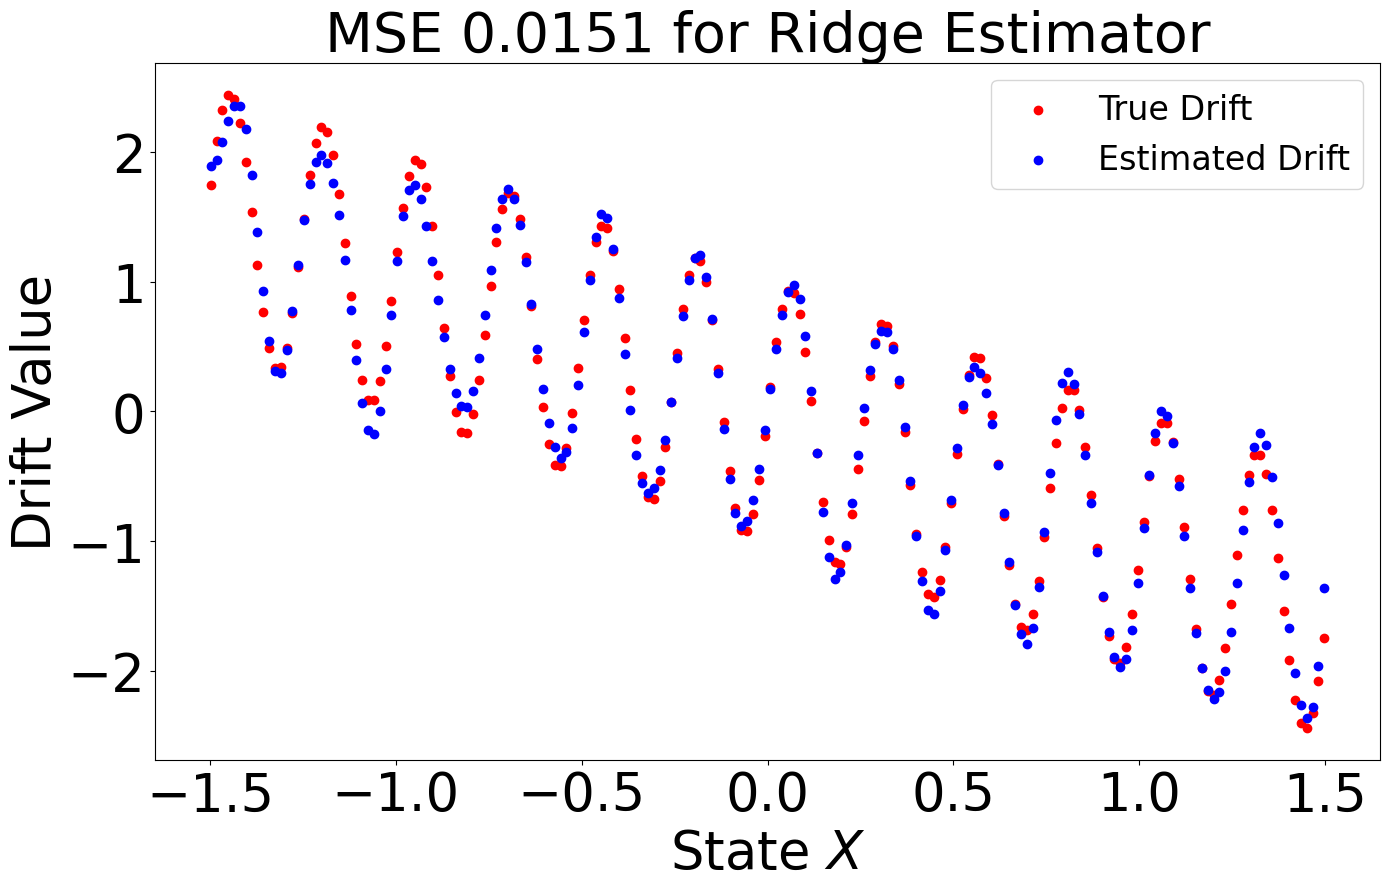

MSE 0.01512027009028583 for KN 34
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



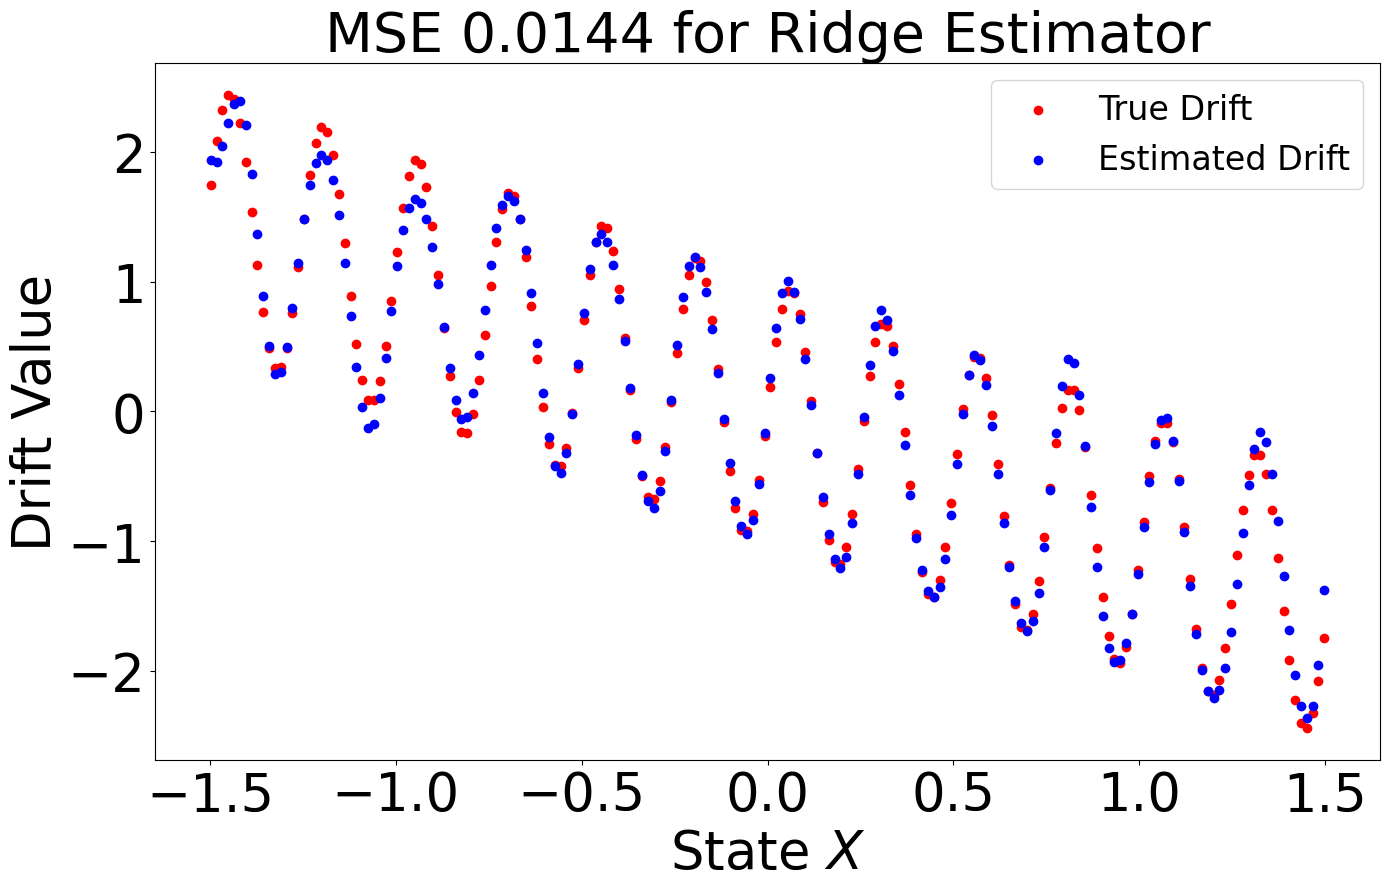

MSE 0.014360201852929333 for KN 35
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constra

In [49]:
KNS = np.arange(30, 60)
curr_rmse = np.inf
for KN in KNS:
    B = spline_basis(paths=paths[:num_paths,:], KN=KN, AN=AN, BN=BN, M=M)
    Z = np.power(deltaT,-1)*np.diff(paths[:num_paths,:], axis=1).reshape((paths[:num_paths,:].shape[0]*(paths.shape[1]-1),1))
    assert (B.shape[0] == Z.shape[0] and len(B.shape)==len(Z.shape) == 2)
    coeffs = find_optimal_estimator_coeffs(B=B, Z=Z, KN=KN, LN=LN, M=M)
    ppaths = np.linspace(AN-0.5, BN+0.5, 256).reshape(1, -1)
    if "QuadSin" in config.data_path:
        unif_true_drift = -2.*config.quad_coeff * ppaths[:,:-1].flatten() + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*ppaths[:,:-1].flatten())
    elif "fSinLog" in config.data_path:
        unif_true_drift = (-np.sin(config.sin_space_scale*ppaths[:,:-1].flatten())*np.log(1+config.log_space_scale*np.abs(ppaths[:,:-1].flatten()))/config.sin_space_scale).flatten()
    elif "BiPot" in config.data_path:
        unif_true_drift = -(4.*config.quartic_coeff * np.power(ppaths[:,:-1], 3) + 2.*config.quad_coeff * ppaths[:,:-1] + config.const).flatten()
    unif_true_drift[ppaths[:,:-1].flatten() < AN] = np.nan
    unif_true_drift[ppaths[:,:-1].flatten() > BN] = np.nan
    unif_B = spline_basis(paths=ppaths[:,:], KN=KN, AN=AN, BN=BN, M=M)
    unif_drift = construct_estimator(coeffs=coeffs, B=unif_B, LN=LN).flatten()
    unif_drift[ppaths[:,:-1].flatten() < AN] = np.nan
    unif_drift[ppaths[:,:-1].flatten() > BN] = np.nan
    rmse = (rmse_ignore_nans(unif_true_drift, unif_drift))
    if rmse < curr_rmse:
        curr_rmse = rmse
        fig, ax = plt.subplots(figsize=(14,9))
        plt.scatter(ppaths[:,:-1].flatten(), unif_true_drift, label="True Drift", color="red")
        plt.scatter(ppaths[:,:-1].flatten(), unif_drift, label="Estimated Drift",color="blue")
        plt.title(f"MSE {round(rmse, 4)} for Ridge Estimator", fontsize=40)
        ax.tick_params(labelsize=38)
        plt.ylabel("Drift Value", fontsize=38)
        plt.xlabel(r"State $X$", fontsize=38)
        plt.legend(fontsize=24)
        plt.tight_layout()
        plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/Ridge_{ts_type}_DriftEvalExp_{KN}KN_{M}M".replace(".","")+".png",  bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"MSE {rmse} for KN {KN}")
# KN=1, M=3 for fBiPot
# KN=10, M=3 for fQuadSin1
# KN=40, M=4 for fQuadSin2 (high frequency)
# KN=43, M=2 for fQuadSin2 (high frequency for clean report)
# KN = 8, m=2 for SinLog

In [50]:
def true_drift(prev, num_paths, config):
    assert (prev.shape == (num_paths, config.ndims))
    if "BiPot" in config.data_path:
        drift_X = -(4. * config.quartic_coeff * np.power(prev, 3) + 2. * config.quad_coeff * prev + config.const)
    elif "QuadSin" in config.data_path:
        drift_X = -2. * config.quad_coeff * prev + config.sin_coeff * config.sin_space_scale * np.sin(
        config.sin_space_scale * prev)
    elif "SinLog" in config.data_path:
        drift_X = (-np.sin(config.sin_space_scale*prev)*np.log(1+config.log_space_scale*np.abs(prev))/config.sin_space_scale)
    return drift_X[:, np.newaxis, :]


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_27572/3788290958.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_27572/3788290958.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))


Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


0.000182233190311228 (0.00010348631678980025, 0.0002892015412950594) inf


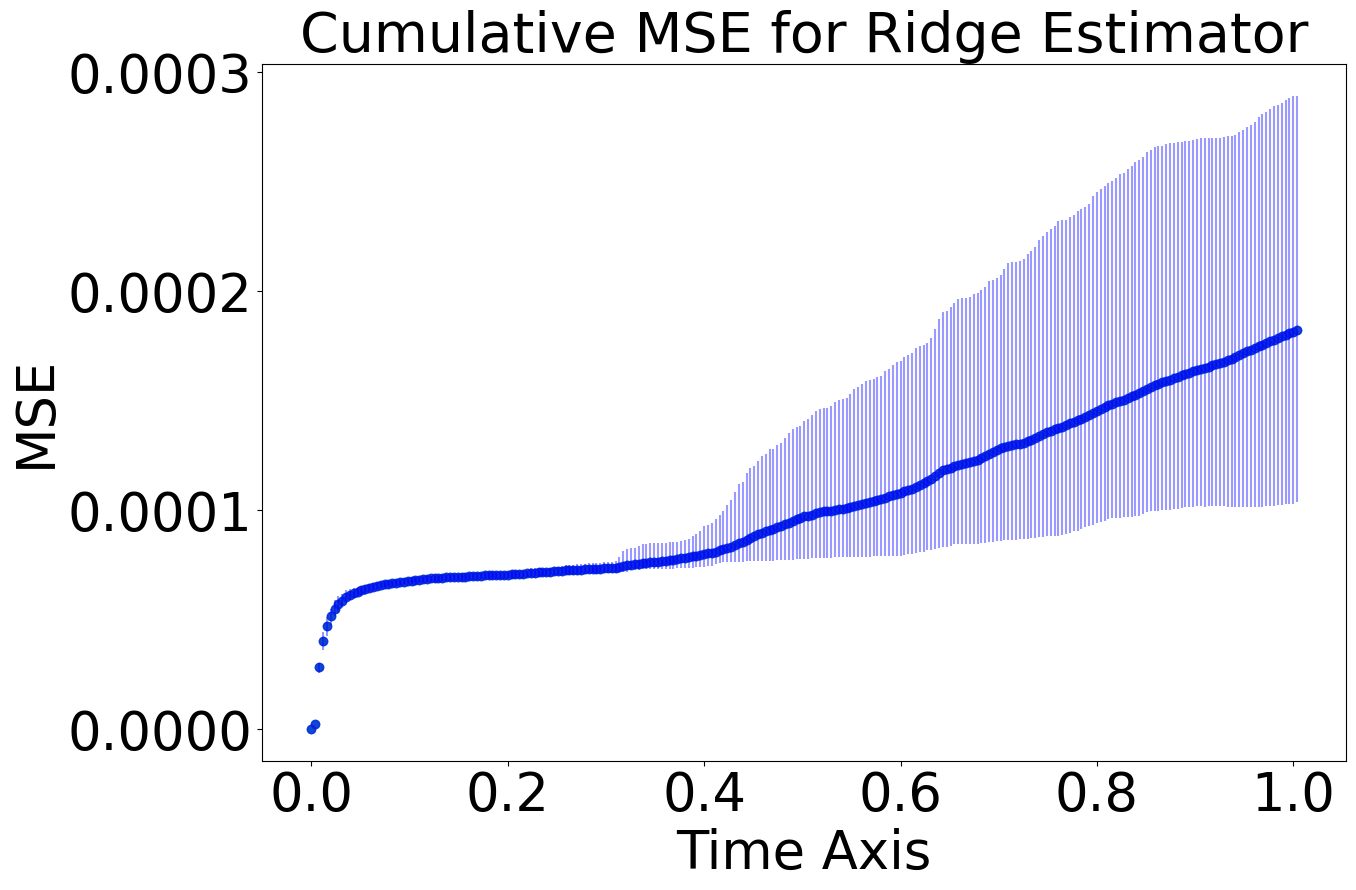

Final time cumulative MSE local-time error 0.000182233190311228 with IQR (0.00010348631678980025, 0.0002892015412950594) at KN 30

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


0.00013455856013943446 (6.238324157104415e-05, 0.0002244036947507329) 0.000182233190311228


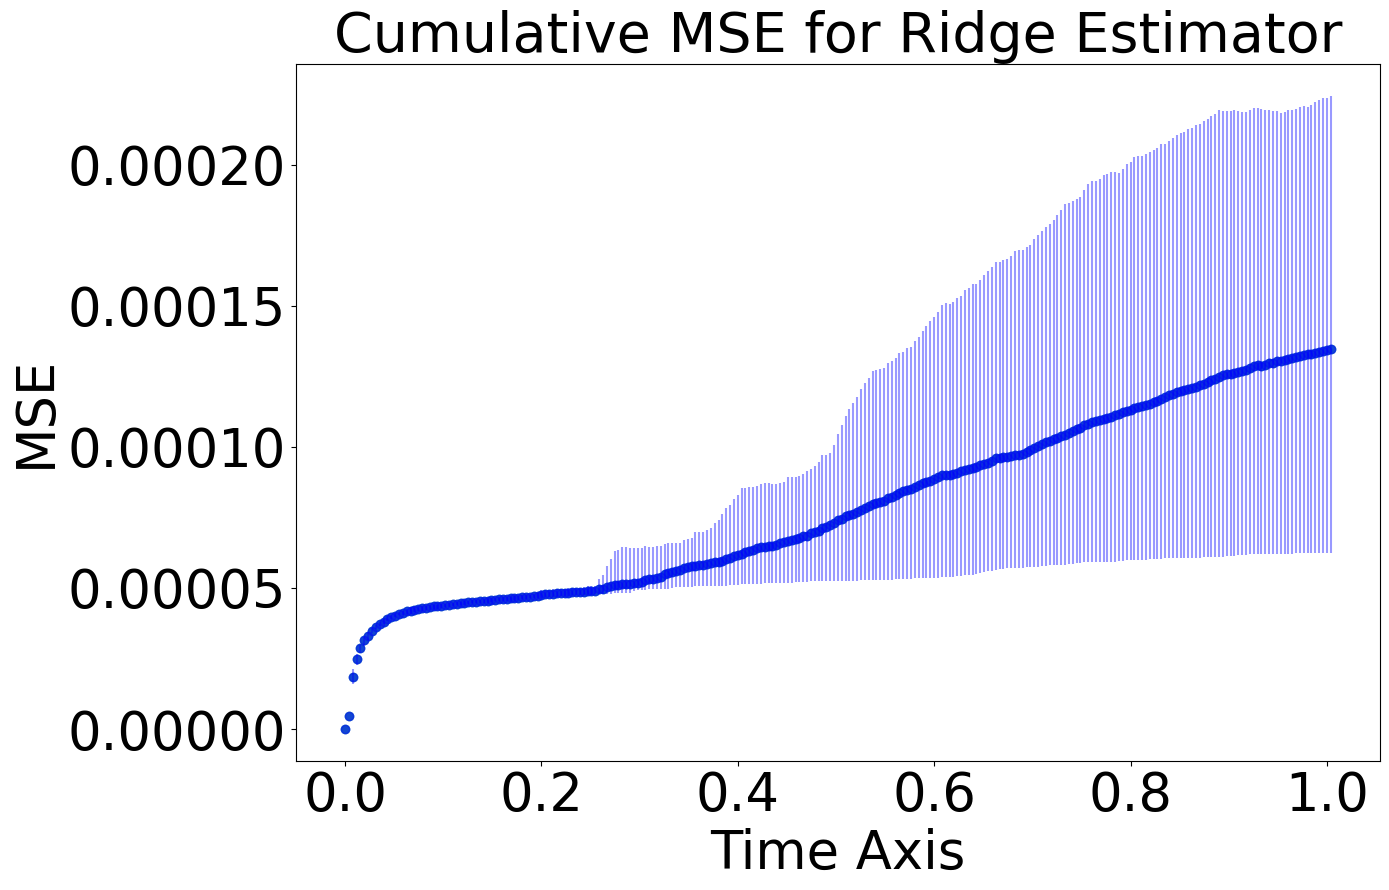

Final time cumulative MSE local-time error 0.00013455856013943446 with IQR (6.238324157104415e-05, 0.0002244036947507329) at KN 31

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


0.00013926365339111388 (9.367384829326286e-05, 0.0001956476724969497) 0.00013455856013943446
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


0.00014279717112598622 (7.627778860198568e-05, 0.00024310194215456242) 0.00013455856013943446
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


0.00012170763993579379 (5.95580993311532e-05, 0.00020632689892061305) 0.00013455856013943446


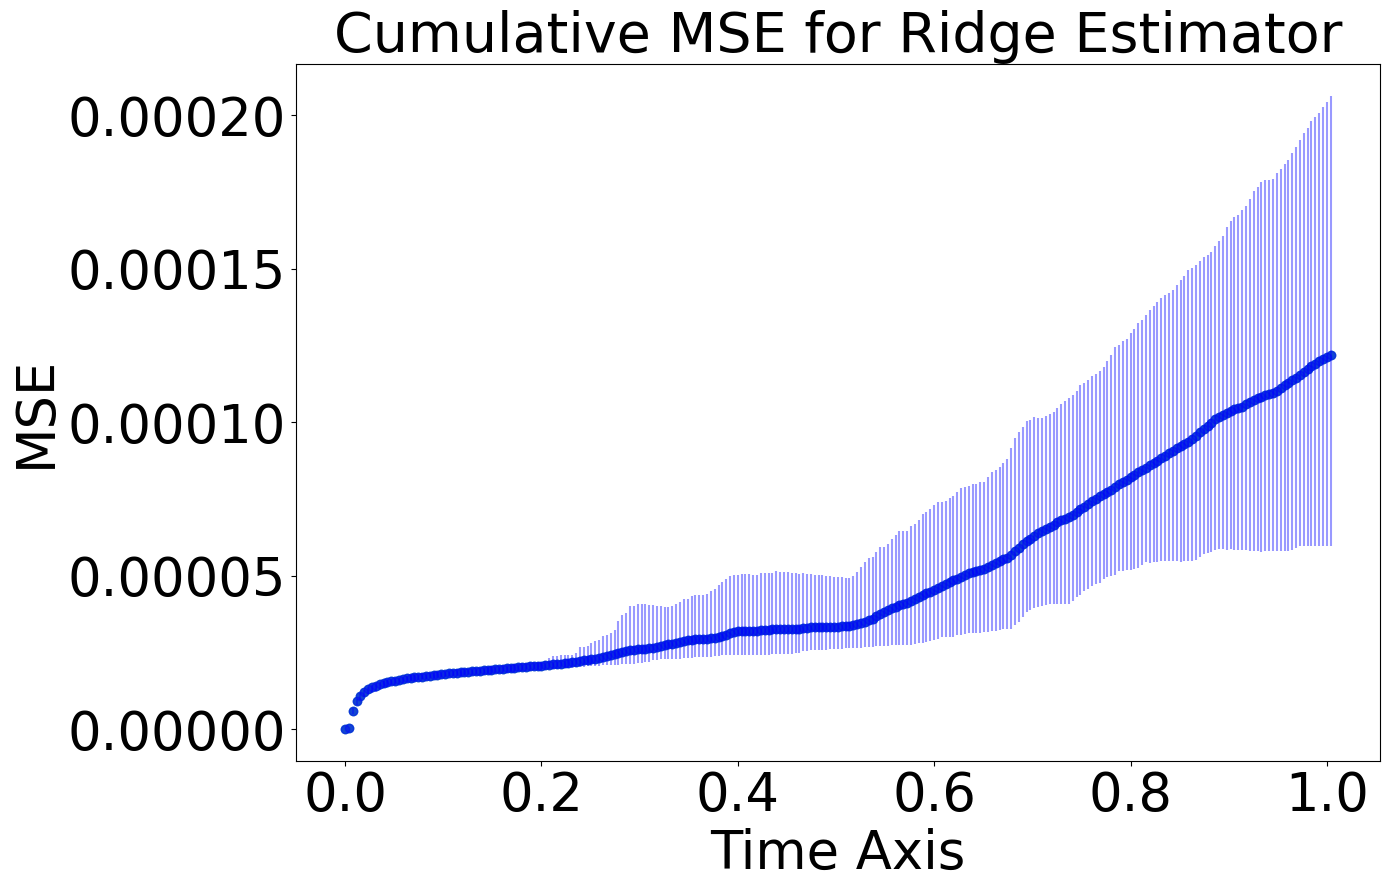

Final time cumulative MSE local-time error 0.00012170763993579379 with IQR (5.95580993311532e-05, 0.00020632689892061305) at KN 34

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


0.00011789933059958183 (4.540541219008624e-05, 0.00018786753546325401) 0.00012170763993579379


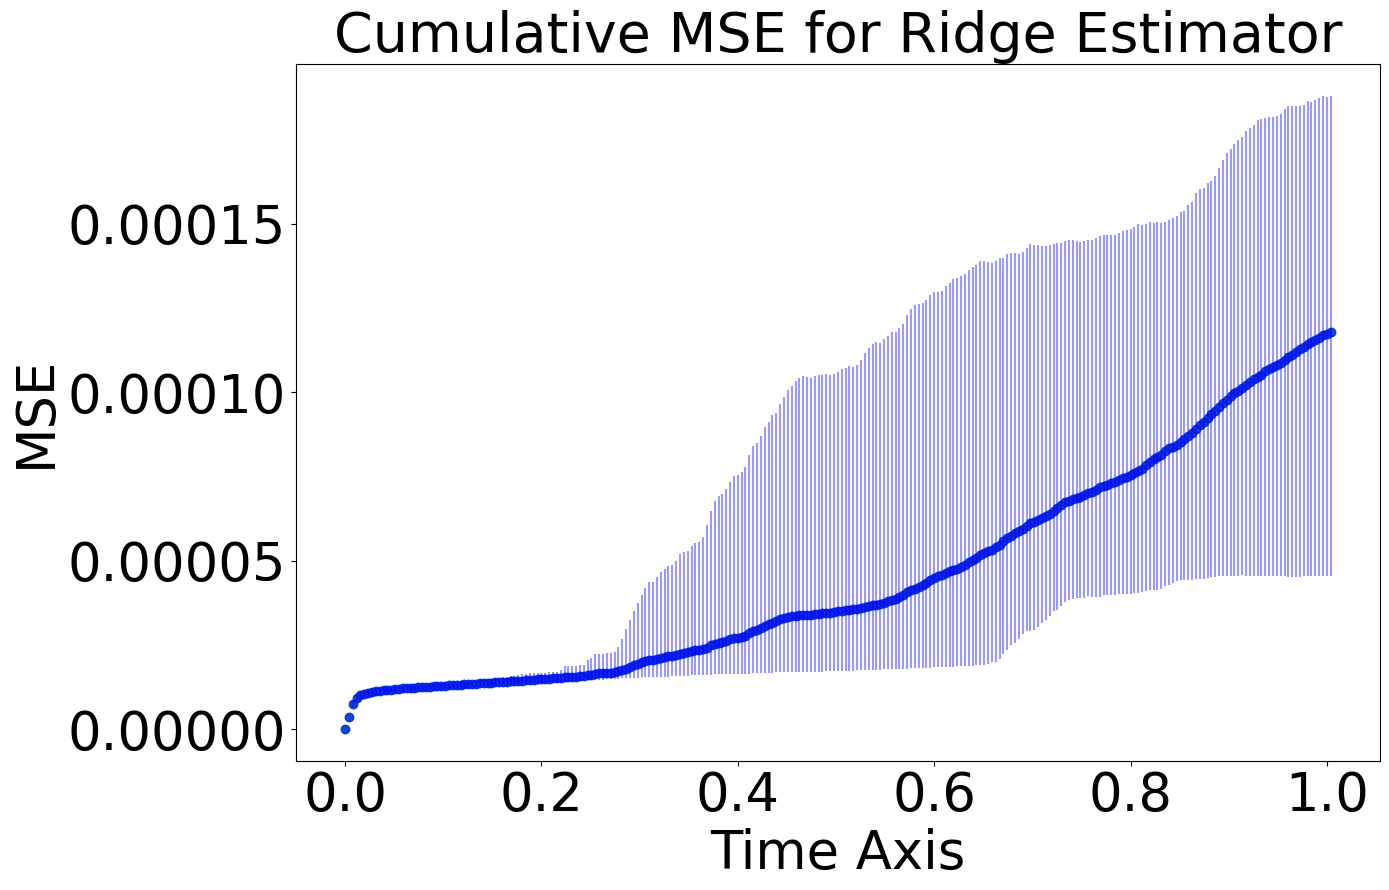

Final time cumulative MSE local-time error 0.00011789933059958183 with IQR (4.540541219008624e-05, 0.00018786753546325401) at KN 35

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


0.0001104215110268571 (4.897386617275159e-05, 0.00020024270941832863) 0.00011789933059958183


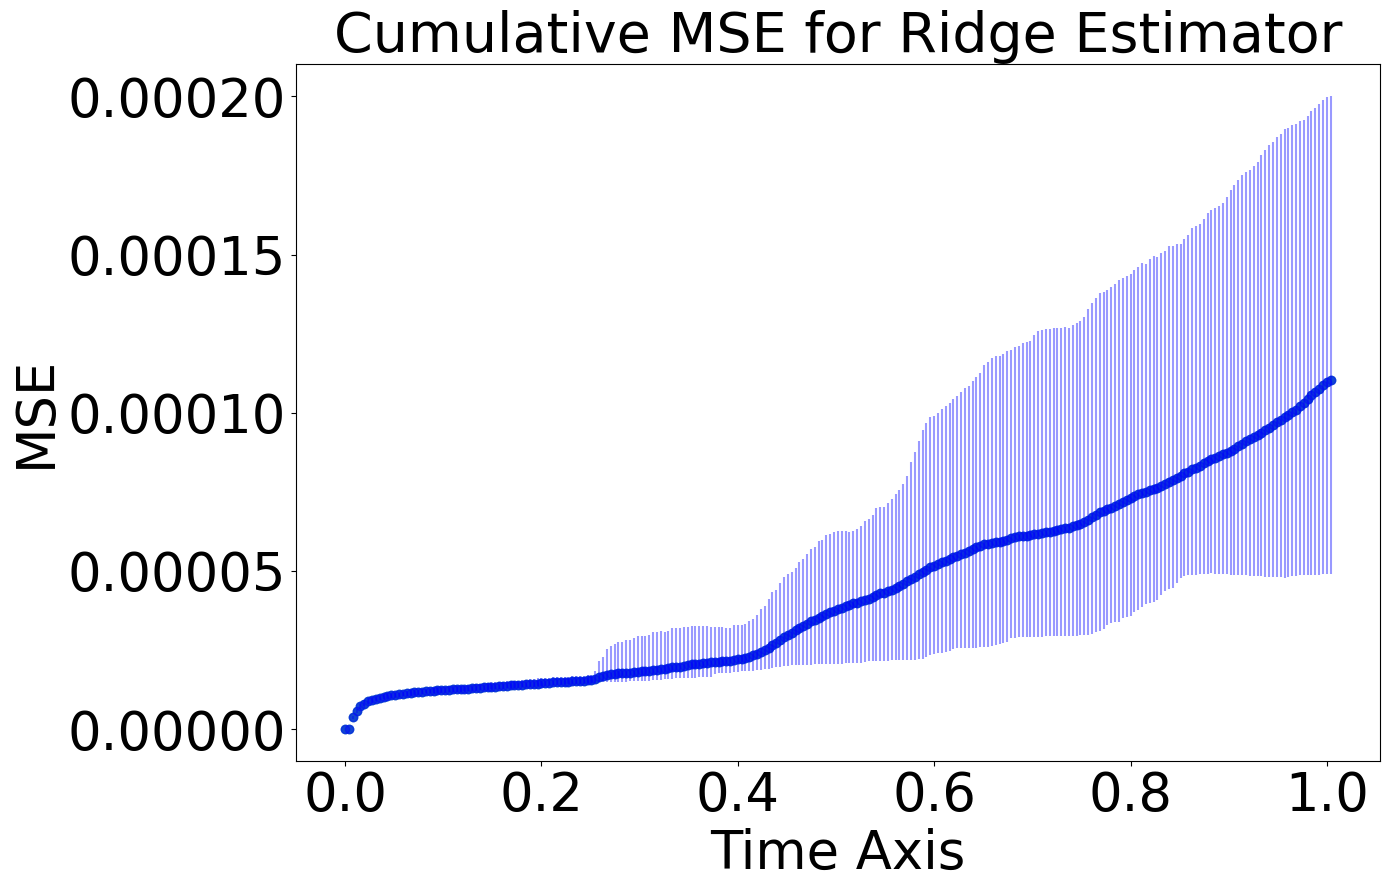

Final time cumulative MSE local-time error 0.0001104215110268571 with IQR (4.897386617275159e-05, 0.00020024270941832863) at KN 36

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


0.00013686558035808663 (4.4570699118368315e-05, 0.00023954425386598564) 0.0001104215110268571
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


0.00011714471091661024 (6.790806317321301e-05, 0.00017310923420766545) 0.0001104215110268571
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


0.0001320943391859535 (5.723230243263823e-05, 0.00022584817517149353) 0.0001104215110268571
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


0.00014127766050182585 (5.36471388032047e-05, 0.0003020294746132901) 0.0001104215110268571
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


0.00012651435014110834 (3.677050821724621e-05, 0.00019213836343450524) 0.0001104215110268571
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


7.399358013967943e-05 (3.57324110958676e-05, 0.00010586626208334433) 0.0001104215110268571


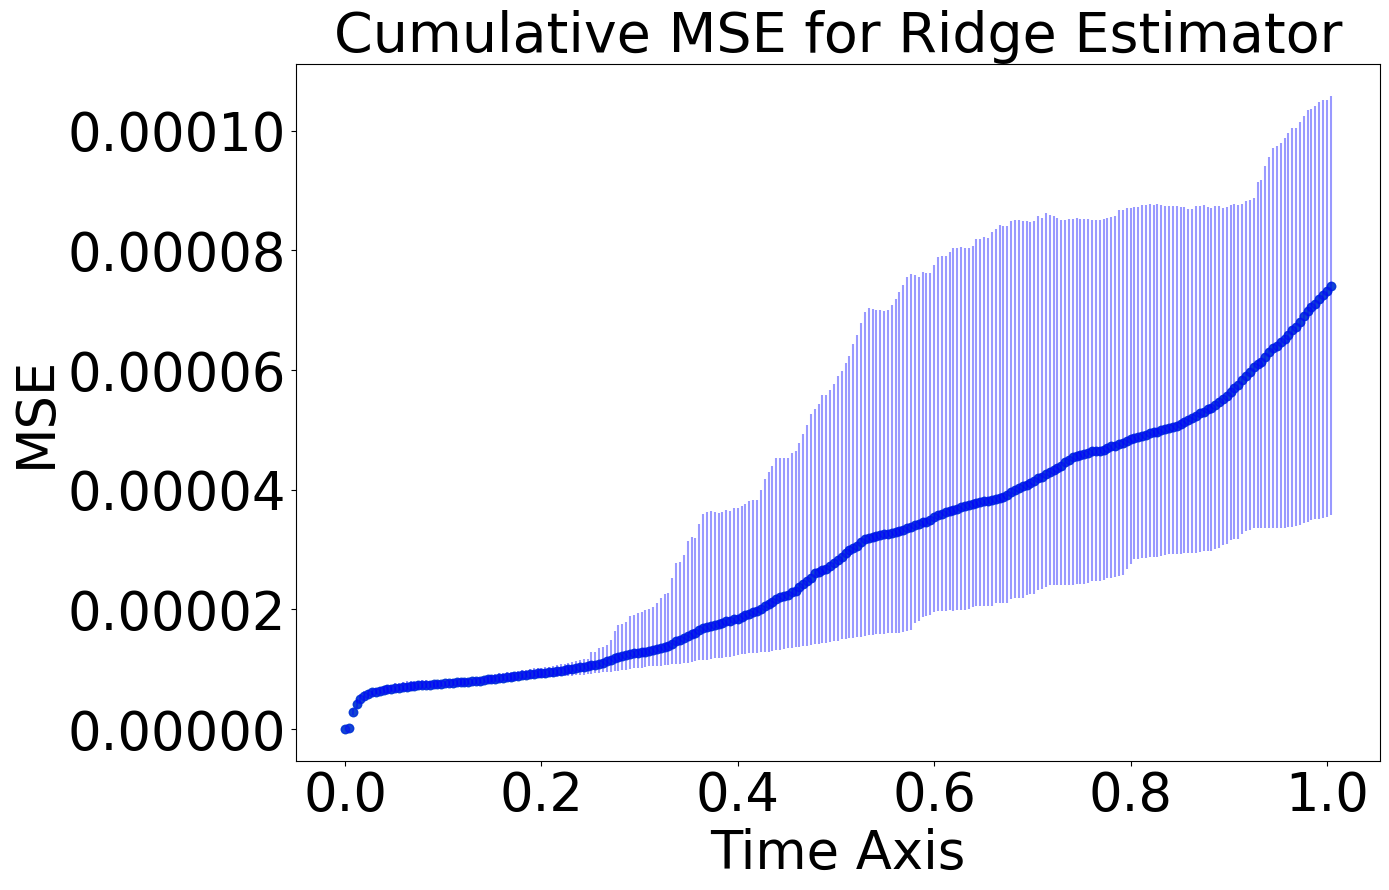

Final time cumulative MSE local-time error 7.399358013967943e-05 with IQR (3.57324110958676e-05, 0.00010586626208334433) at KN 42

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


0.00010122972195694152 (4.73851520492725e-05, 0.0001753842032840752) 7.399358013967943e-05
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


0.0001292210490421549 (4.3187809109958176e-05, 0.0003256489207784758) 7.399358013967943e-05
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


0.00012069998738546594 (2.7822284275843905e-05, 0.00030095817371078966) 7.399358013967943e-05
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


0.00010410145974251376 (3.5514176187931174e-05, 0.00019148112289663652) 7.399358013967943e-05
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


0.00013313272575813515 (5.1332619459495854e-05, 0.00021897732501620292) 7.399358013967943e-05
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


0.0001330384644263125 (4.131846544724484e-05, 0.00029146805337239713) 7.399358013967943e-05
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


0.00015419794316087965 (4.55129774377377e-05, 0.0002382954350767261) 7.399358013967943e-05
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


0.00012596197484729223 (6.363221809414076e-05, 0.00019940640572374164) 7.399358013967943e-05
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


0.00014744468472446131 (4.6064014916029415e-05, 0.00024443178101754803) 7.399358013967943e-05
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


0.000119849259413506 (5.993616980997701e-05, 0.00018083028786986834) 7.399358013967943e-05
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


9.770156268203456e-05 (3.884010100591859e-05, 0.00023226908869898184) 7.399358013967943e-05
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


0.00010430126036138035 (4.663427936612899e-05, 0.00020173822797961655) 7.399358013967943e-05
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


0.0001615472040408577 (8.235109947151212e-05, 0.0003091354093819053) 7.399358013967943e-05
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


0.00010249764936723905 (5.219183157671017e-05, 0.00020368326270970254) 7.399358013967943e-05
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


0.00011113228396394774 (6.193908848419327e-05, 0.00018003869754556006) 7.399358013967943e-05
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


0.00010988436151064384 (4.655841377479728e-05, 0.00024803310585203676) 7.399358013967943e-05
Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

9.39400373865033e-05 (3.3155957966040664e-05, 0.00015433347945451002) 7.399358013967943e-05


In [51]:
best_rmse = np.inf
toSave = True
num_time_steps = 256
num_state_paths = 100
rmse_quantile_nums = 10
LN = np.log(num_paths)
KNS = np.arange(30, 60)
for k_idx in range(len(KNS)):
    KN = KNS[k_idx]
    all_true_states = np.zeros(shape=(rmse_quantile_nums, num_state_paths, 1 + num_time_steps, config.ndims))
    # all_global_states = np.zeros(shape=(rmse_quantile_nums, num_state_paths, 1 + num_time_steps, config.ndims))
    all_local_states = np.zeros(shape=(rmse_quantile_nums, num_state_paths, 1 + num_time_steps, config.ndims))
    assert (all_true_states.shape == all_local_states.shape)
    # assert (all_global_states.shape == all_local_states.shape)
    B = spline_basis(paths=paths[:num_paths,:], KN=KN, AN=AN, BN=BN, M=M)
    Z = np.power(deltaT,-1)*np.diff(paths[:num_paths,:], axis=1).reshape((paths[:num_paths,:].shape[0]*(paths.shape[1]-1),1))
    assert (B.shape[0] == Z.shape[0] and len(B.shape)==len(Z.shape) == 2)
    coeffs = find_optimal_estimator_coeffs(B=B, Z=Z, KN=KN, LN=LN, M=M)
    for quant_idx in tqdm(range(rmse_quantile_nums)):
        true_states = np.zeros(shape=(num_state_paths, 1 + num_time_steps, config.ndims))
        global_states = np.zeros(shape=(num_state_paths, 1 + num_time_steps, config.ndims))
        local_states = np.zeros(shape=(num_state_paths, 1 + num_time_steps, config.ndims))
        # Initialise the "true paths"
        true_states[:, [0], :] = config.initState
        # global_states[:, [0], :] = config.initState
        local_states[:, [0], :] = config.initState
        for i in (range(1, num_time_steps + 1)):
            eps = np.random.randn(num_state_paths, 1, config.ndims) * np.sqrt(deltaT)
            assert (eps.shape == (num_state_paths, 1, config.ndims))
            true_mean = true_drift(true_states[:, i - 1, :], num_paths=num_state_paths, config=config)
            local_basis = spline_basis(paths=true_states[:, i - 1, :], KN=KN, AN=AN, BN=BN, M=M)
            local_mean = construct_estimator(coeffs=coeffs, B=local_basis, LN=LN)[:, np.newaxis, :]
            true_states[:, [i], :] = true_states[:, [i - 1], :] + true_mean * deltaT + eps
            # global_states[:, [i], :] = global_states[:, [i - 1], :] + global_mean * deltaT + eps
            local_states[:, [i], :] = true_states[:, [i - 1], :] + local_mean * deltaT + eps
        all_true_states[quant_idx, :, :, :] = true_states
        all_local_states[quant_idx, :, :, :] = local_states
    all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2)/config.deltaT, axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
    total_local_errors = np.mean((all_local_errors), axis=0)
    total_local_errors_minq = np.quantile((all_local_errors), axis=0,q=0.025)
    total_local_errors_maxq = np.quantile((all_local_errors), axis=0,q=0.975)
    print(total_local_errors[-1], (total_local_errors_minq[-1], total_local_errors_maxq[-1]), best_rmse)
    if total_local_errors[-1]  < best_rmse:
        time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
        best_rmse = total_local_errors[-1] #- total_local_errors_minq[-1]
        fig, ax = plt.subplots(figsize=(14,9))
        ax.scatter(time_steps, total_local_errors)
        plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)
        ax.set_title(f"Cumulative MSE for Ridge Estimator",fontsize=40)
        plt.tight_layout()
        ax.set_xlabel("Time Axis", fontsize=38)
        ax.tick_params(labelsize=38)
        ax.set_xlabel("Time Axis", fontsize=38)
        ax.tick_params(labelsize=38)

        fig.canvas.draw()
        # Get the offset text (e.g., '1e-5')
        offset_text = ax.yaxis.get_offset_text().get_text()

        # Remove the offset text from the axis
        ax.yaxis.get_offset_text().set_visible(False)

        # Inject the scale into the y-axis label
        if offset_text:
            ax.set_ylabel(f'MSE ({offset_text})', fontsize=38)
        else:
            ax.set_ylabel('MSE', fontsize=38)
        plt.tight_layout()
        if toSave:
            plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/Ridge_{ts_type}_DriftTrack_{KN}KN_{M}M_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
        plt.show()
        plt.close()
        print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at KN {KN}\n")
